# Negative Review Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re

import pymongo

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
    
from wordcloud import WordCloud,STOPWORDS 
from matplotlib import rcParams
from collections import Counter


# SETTING
plt.style.use('ggplot')
#display maximum column and rows
pd.options.display.max_columns = 999
pd.options.display.min_rows = 999
pd.options.display.max_colwidth = 999
stopword = STOPWORDS
stopword.add('im')
stopword.add('youre')


red = '#ef4b4b'
black = '#584b42'
green = '#a0cc78'
yellow_ = '#f6d365'
blue_ = '#49beb7'

#INIT
vader = SentimentIntensityAnalyzer()


#METHODS
def sep():
    print(100*'-')

def connectMongoDB(dbname):
    client = pymongo.MongoClient('localhost', 27017)
    db = client[dbname]
    return db

dbname = 'clothing_fit'
db = connectMongoDB(dbname)

In [3]:
rent = list(db.rentCollection.find())
df_rent = pd.DataFrame(rent)
df_rent

# MENGECEK NULL
df_rent.isnull().sum()
# df_rent.info()

_id                     0
fit                     0
user_id                 0
bust size            1901
item_id                 0
weight               3161
rating                  0
rented for              0
review_text             0
body type            1510
review_summary          0
category                0
height                 76
size                    0
age                   103
review_date             0
sentiment_              0
height_cm               0
weight_kg            3161
age_                    0
review_date_            0
sentiment_summary       0
sentiment_text          0
dtype: int64

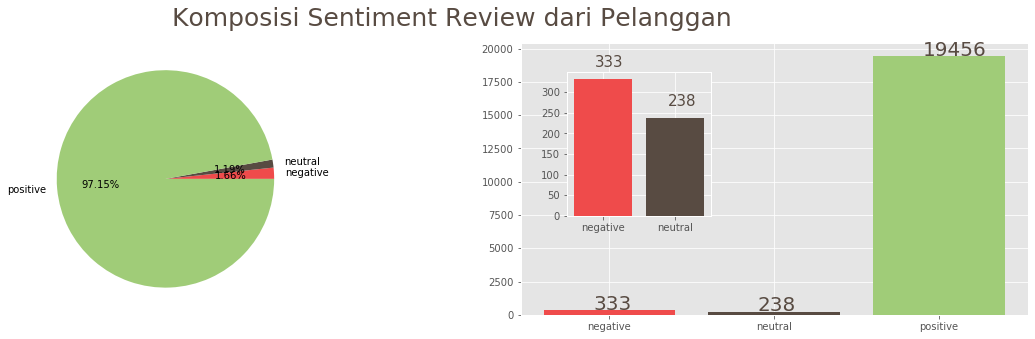

In [4]:
sums = df_rent.sentiment_.groupby(df_rent.sentiment_).count()
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Sentiment Review dari Pelanggan', fontsize='25', color=black)

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red,black,green] )

plt.subplot(122)
index = sums.index
count = sums.tolist()

plt.bar(index[:],count[:], color=[red,black,green])
for i, v in enumerate(count[:]):
    plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='20')

# ZOOM IN perbandingan sentiment negatif dan netral
ax = fig.add_axes([0.58,0.4,0.1,0.4])
plt.bar(index[:2],count[:2], color=[red,black,])
for i, v in enumerate(count[:2]):
    plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='15')
plt.show()
# sums

## Memisahkan Review Negatif Untuk Mencari Tahu Insight:
###  - Faktor apa saja yang memengaruhi review negatif customer ?

Di Bawah ini adalah contoh data yang memiliki feedback review negatif

In [5]:
df_rent[df_rent.sentiment_ == 'negative'][['review_text','review_summary', 'sentiment_']].tail(20)


,review_text,review_summary,sentiment_
18961,"As always, RTR's customer service is top notch and was pleased that I received a brand new dress (tags still on). As a regular customer of RTR, I've had the pleasure of renting some awesome dresses but this one to me was just so-so. I didn't think it was very flattering on my body (shows the ""pooch""/tummy) and the back isn't as sexy as I thought since even though there is the slit, there is fabric under it. I got compliments so maybe I'm just a harsh critic but I wasn't a fan.",Meh - not my favorite,negative
19028,"I loved another E&J rental, so I thought it would fit similarly, but was very disappointed with this rental, as I couldn't wear it for my birthday as I had planned. I rented bigger, but the dress was still way too short to wear anywhere but a club. I have a moderately sized chest but it was still loose in the armpits. Not sure who this dress actually fits, as it was short on me and I'm only 5'6.",Very short but big in chest,negative
19220,Fabric is uncomfortable around the armpits. Fit is a bit strange. Wouldn't rent again.,Okay but not great.,negative
19287,"This dress was a perfect fit for me. I usually have trouble with strapless staying up, but this dress wasn't budging at all. It was a bit heavy but not too overwhelming. Should be worn with a strapless bra although I didn't wear one .",Stylist Review,negative
19306,A little short for me.,Worn to birthday dinner date,negative
19336,"This dress looked so hot in the pictures online. Super flattering, but I have a pretty flat figure, and this dress only seemed to emphasize the lack of distinction between waste and hips.",Not so great for ladies without curves,negative
19417,"I was absolutely swimming in this. Should have ordered the smallest size... unique cut, might order again in XXS.",Order down...,negative
19442,"the dress cinched in a very awkward way, the way it folded over was not flattering on the tummy area","good quality, bad fit",negative
19462,I ignored the other reviews and shouldn't have. This dress is short and runs small. The fabric is tighter and more constricting than it looks. Could not wear this to work. Didn't want to waste a rental so I wore it over the weekend and was uncomfortable.,Not for curves,negative
19477,I didn't get to wear it because the back was too baggy and open. Wasn't flattering. :(,Not figure flattering.,negative


In [6]:
negatifReview = df_rent[df_rent.sentiment_ == 'negative']['review_text']
print("Banyak review negatif : ", len(negatifReview))

Banyak review negatif :  333


### Dari sekian banyak review negatif customer, ternyata bisa dilihat tidak semua kalimatnya mengandung komplain. 

contoh : 

```As always, RTR's customer service is top notch and was pleased that I received a brand new dress (tags still on). As a regular customer of RTR, I've had the pleasure of renting some awesome dresses but this one to me was just so-so. I didn't think it was very flattering on my body (shows the "pooch"/tummy) and the back isn't as sexy as I thought since even though there is the slit, there is fabric under it. I got compliments so maybe I'm just a harsh critic but I wasn't a fan.```


Untuk itu, saya mencoba untuk mengidentifikasi perkalimatnya, item-item yang customer sebutkan di dalam kalimat-kalimat komplain ini akan memberikan insight penyebab apakah mereka kecewa dalam bertransaksi dengan RTR (company)

## Memisahkan kalimat-kalimat di dalam review negatif

In [7]:
dokumen_input = negatifReview
negatifReview_sentences = []

for i in range(len(dokumen_input)):
    review = negatifReview.iloc[i]
    sentence = sent_tokenize(review)
    negatifReview_sentences.extend(sentence)
sep()
print("Banyak Kalimat di dalam review negatif : ", len(negatifReview_sentences))

df_rev_neg_sent = pd.DataFrame(negatifReview_sentences)
# df_rev_neg_sent

----------------------------------------------------------------------------------------------------
Banyak Kalimat di dalam review negatif :  1180


### mendapatkan sentiment dari tiap-tiap kalimat customer

In [8]:
# melakukan analisa per kalimat di dalam review
# get sentiment score
dokumen_input = negatifReview_sentences
listSentimenSentence = []

for i in dokumen_input:
    sentimen = vader.polarity_scores(i)['compound']
    listSentimenSentence.append(sentimen)

df_rev_neg_sent['angka_sent'] = listSentimenSentence
# df_rev_neg_sent

In [9]:
len(listSentimenSentence)
df_rev_neg_sent['sent'] = df_rev_neg_sent.angka_sent.apply(lambda x : 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral' ))
neg = df_rev_neg_sent[df_rev_neg_sent['sent']=='negative']
pos = df_rev_neg_sent[df_rev_neg_sent['sent']=='positive']
neu = df_rev_neg_sent[df_rev_neg_sent['sent']=='neutral']
all = df_rev_neg_sent.copy()

print("jumlah neg sentence dari neg review : ", len(neg)) # this is very concern of this analysis (PRIORITY)
print("jumlah pos sentence dari neg review : ", len(pos)) # low
print("jumlah neu sentence dari neg review : ", len(neu)) # moderate


jumlah neg sentence dari neg review :  486
jumlah pos sentence dari neg review :  265
jumlah neu sentence dari neg review :  429


### Di bawah ini adalah contoh kalimat yang memiliki sentimen negatif dari customer

In [10]:
neg.head()

,0,angka_sent,sent
2,this was not flattering on my curves.,-0.2411,negative
5,boxy and weird.,-0.1779,negative
7,not great for woman with curves.,-0.5096,negative
8,I rented this dress thinking I would wear it to work but it looked a little too well worn and had an overused look that I didn't like.,-0.4285,negative
11,"I always get compliments when I wear RTR dresses, but not with this one for some reason....the pockets stuck out; I should've taped them down.",-0.1655,negative


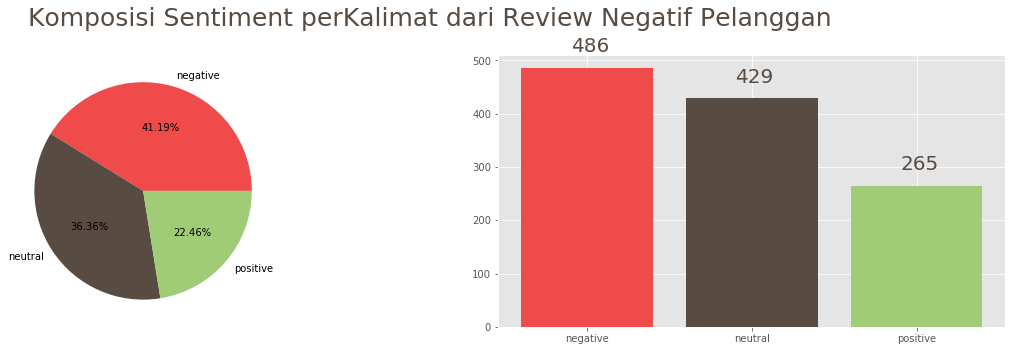

In [11]:
sums = df_rev_neg_sent.sent.groupby(df_rev_neg_sent.sent).count()
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Sentiment perKalimat dari Review Negatif Pelanggan', fontsize='25', 
             color=black, 
            va='center')

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red,black,green] )

plt.subplot(122)
index = sums.index
count = sums.tolist()

plt.bar(index[:],count[:], color=[red,black,green])
for i, v in enumerate(count[:]):
    plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='20')

# ZOOM IN perbandingan sentiment negatif dan netral
# ax = fig.add_axes([0.58,0.4,0.1,0.4])
# plt.bar(index[:2],count[:2], color=[red,black,])
# for i, v in enumerate(count[:2]):
#     plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='15')
plt.show()
# sums

##### 1. priority : Dari sini, kita akan mencari tahu keyword apa saja yang berada dalam kalimat2 negatif customer


In [12]:
sums

sent
negative    486
neutral     429
positive    265
Name: sent, dtype: int64

##### mulai memproses kalimat negatif customer

<hr>

# Preprocessing Text Data
1. PUNCTUATION REMOVAL - menggunakan regular expression
2. LOWERCASE TRANSFORMATION
3. TOKENIZING + STOPWORD REMOVAL - menggunakan stopword dari NLTK.corpus dan Wordcloud
4. POS tagging + Lemmatization - NLTK pos_tag untuk POS tagging dan WordNetLemmatizer untuk Lemmatisasi

In [13]:
# update stopwords

stop_words = list(stopwords.words('english'))
stop_words.append('the')

In [14]:
# LEMMATIZER HELPER - karena proses lematisasi menggunakan wordnet lematizer, 
# dia butuh tag POS untuk parameternya

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
tag_map['N'] = wn.NOUN
print(wn.ADJ)
print(wn.VERB)
print(wn.ADV)

# LEMMATIZER
lmtzr = WordNetLemmatizer()


a
v
r


In [15]:
# EXAMPLE
# LEMMATIZING EXAMPLE

text = "Another way of achieving this task"
tokens = word_tokenize(text)

for token, tag in pos_tag(tokens):
    sep()
    print(token, tag[0], tag_map[tag[0]])
    lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
    print(token, "=>", lemma)

----------------------------------------------------------------------------------------------------
Another D n
Another => Another
----------------------------------------------------------------------------------------------------
way N n
way => way
----------------------------------------------------------------------------------------------------
of I n
of => of
----------------------------------------------------------------------------------------------------
achieving V v
achieving => achieve
----------------------------------------------------------------------------------------------------
this D n
this => this
----------------------------------------------------------------------------------------------------
task N n
task => task


# Memproses Kalimat Negatif dalam review Negatif

In [58]:
# PREPROCESSING TEXT
dokumen_input =  neg.loc[:,0]
# neg.loc[:,0]
# selecting kalimat

print("banyak dokumen input : ", len(dokumen_input))

hasil_preprocessing = []
for i in dokumen_input:
    text = re.sub(r'[^\w\s]','',i)            # PUNCTUATION REMOVAL
    text = text.lower()                       # LOWERCASE TRANSFORMATION
    word_tokens = word_tokenize(text)         # TOKENIZING # memecah kalimat jadi kata
    
    filtered_sentence = []
    for token, tag in pos_tag(word_tokens):           # eksekusi sesuatu pada tiap token kata
        if token not in stop_words:                   # STOPWORD REMOVAL
            if token not in stopword:
                lemma = lmtzr.lemmatize(token, tag_map[tag[0]])  # POS tagging + Lematisasi
    #             print(token, "=>", lemma)
                filtered_sentence.append(lemma)
#     print(filtered_sentence)
    text = (' ').join(filtered_sentence)      # REFORM SENTENCE
    hasil_preprocessing.append(text)

print("banyak dokumen hasil :", len(hasil_preprocessing))

banyak dokumen input :  486
banyak dokumen hasil : 486


#### Di bawah ini adalah hasil setelah dilakukan preprocessing

In [59]:
hasil_preprocessing[:10]

['flatter curve',
 'boxy weird',
 'great woman curve',
 'rent dress thinking wear work look little well worn overused look didnt',
 'always compliment wear rtr dress one reasonthe pocket stick shouldve tap',
 'think smart sharp look dress wasnt best',
 'couldnt walk five foot without get compliment',
 'miss every single day think go buy',
 'didnt way fabric clung hip midsection',
 'top flap romper inner fabric hang frustrate couldnt fix']

In [60]:

# EXAMPLE hitung PREKUENSI KATA

list1=['apple','egg','apple','banana','egg','apple']
counts = Counter(list1)
print(counts)
kata = counts.keys()
count_kata = counts.values()
df_x = pd.DataFrame(count_kata, index = kata)
df_x

Counter({'apple': 3, 'egg': 2, 'banana': 1})


,0
apple,3
egg,2
banana,1


In [61]:
# MENDAPATKAN SEMUA TOKEN DARI HASIL PREPROCESS

dokumen_input = hasil_preprocessing
dokumen_input

all_tokens = []
for i in dokumen_input:
    word_tokens = word_tokenize(i)
    all_tokens.extend(word_tokens)


In [62]:
# HITUNG FREKUENSI MASING2 KATA
print("semua kata dalam token : ", len(all_tokens))
dokumen_input = all_tokens

counts = Counter(dokumen_input)
kata = counts.keys()
count_kata = counts.values()
df_x = pd.DataFrame(count_kata, index = kata)
df_x = df_x.sort_values(0,ascending=False)

kata = df_x.index
count_kata = df_x[0].tolist()

semua kata dalam token :  3428


In [63]:
dokumen_input = kata

benda = []
sifat = []
kerja = []
lain2 = []
all_tag = []
for token, tag in pos_tag(dokumen_input):
#     print(token," =>", tag)
    all_tag.append(tag)
    if tag[0] == 'N':
        benda.append(token)
    elif tag[0] == 'J':
        sifat.append(token)
    elif tag[0] == 'V':
        kerja.append(token)
    else :
        lain2.append(token)
        
df_kata = df_x.copy()
df_kata['POS'] = all_tag

print("jumlah semua kata unik : ", len(df_kata))
print("jumlah kata benda : ", len(benda))
print("jumlah kata sifat : ", len(sifat))
print("jumlah kata kerja : ", len(kerja))
print("jumlah kata lain2 : ", len(lain2))
sep()
print("20 Keyword teratas")
df_kata.head(25)

jumlah semua kata unik :  966
jumlah kata benda :  442
jumlah kata sifat :  271
jumlah kata kerja :  109
jumlah kata lain2 :  144
----------------------------------------------------------------------------------------------------
20 Keyword teratas


,0,POS
dress,161,NN
wear,84,JJ
didnt,65,JJ
fit,55,NN
size,43,NN
look,43,VB
way,34,NN
bra,29,IN
low,28,JJ
wasnt,27,NN


#### Mendapatkan 25 Keyword Teratas 

In [64]:
print(len(df_kata))
df_kata[0][0:26]
df_kata.index.tolist()[0:26]

966


['dress',
 'wear',
 'didnt',
 'fit',
 'size',
 'look',
 'way',
 'bra',
 'low',
 'wasnt',
 'cut',
 'loose',
 'make',
 'zipper',
 'waist',
 'little',
 'one',
 'back',
 'bit',
 'fabric',
 'area',
 'material',
 'hip',
 'love',
 'long',
 'really']

c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.


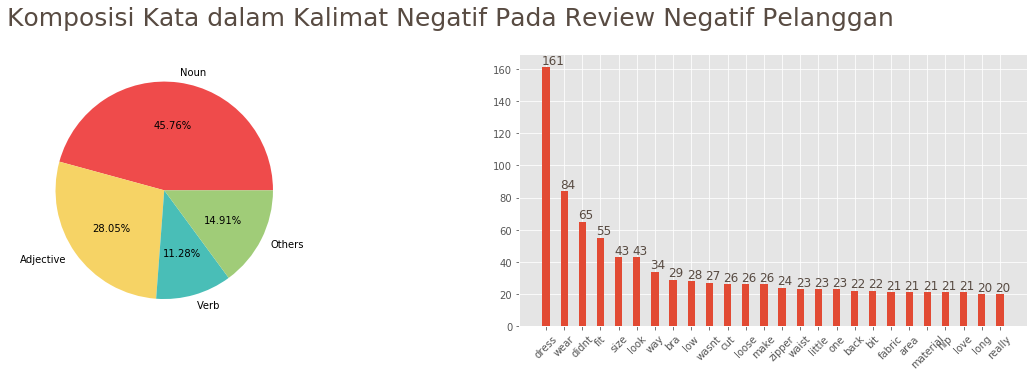

In [65]:
sums = pd.DataFrame([len(benda), len(sifat), len(kerja), len(lain2)] , index=['Noun', 'Adjective', 'Verb', 'Others'])
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Kata dalam Kalimat Negatif Pada Review Negatif Pelanggan', fontsize='25', 
             color=black, 
            va='center')

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red,yellow_,blue_, green] )

plt.subplot(122)
heights = df_kata[0][0:26]
tick_labels = df_kata.index.tolist()[0:26]

plt.bar(range(0, 52, 2), heights)
for i, v in enumerate(heights):
    plt.text(i*2 - 0.5,v+2 , str(v), color=black, fontsize='12')

plt.xticks(range(0,52,2),tick_labels , rotation=45)
# print(df_kata.index)

lcs, labels = plt.xticks()
# print(lcs)
plt.show()

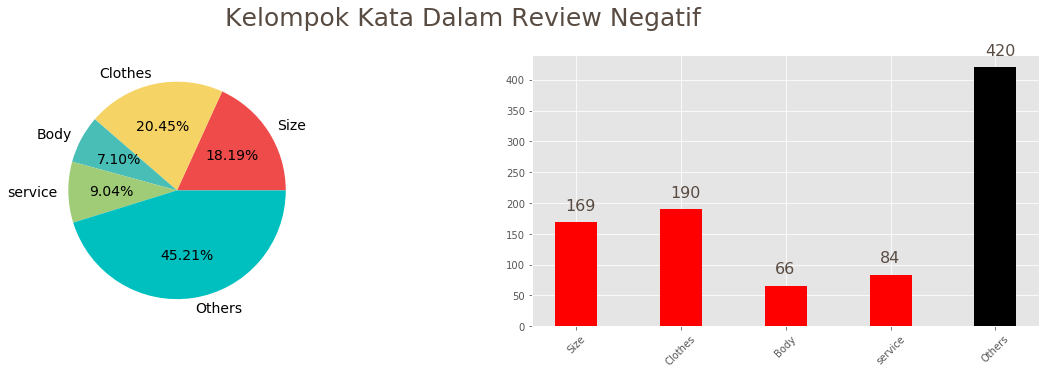

In [69]:
heights = df_kata[0][0:26]
tick_labels = df_kata.index.tolist()[0:26]
tick_labels

size_term = ['size', 'fit', 'small', 'little', 'short', 'long', 'large', 'tight', 'low']
cloth_term = ['look', 'fabric', 'material', 'bra', 'cut', 'loose', 'zipper', 'picture']
body_term = ['waist', 'back', 'hip']
service_term = ['wear', 'rent' , 'order']
general = [ 'dress','didnt', 'work', 'bit', 'way', 'wasnt', 'even', 'end', 'one', 'bit', 'area', 'love', 'really', 'make']


counts_term = [0,0,0,0, 0]
for i in tick_labels:
    n = heights[tick_labels.index(i)]
    if i in size_term:
        counts_term[0]+= n
    elif i in cloth_term:
        counts_term[1]+=n
    elif i in body_term:
        counts_term[2]+= n
    elif i in service_term:
        counts_term[3]+= n
    else:
        counts_term[4]+=n
            
# print(counts_term)

fig = plt.figure(figsize=(20,5))
plt.suptitle("Kelompok Kata Dalam Review Negatif", fontsize='25', 
             color=black, 
            va='center')

plt.subplot(121)
plt.pie(counts_term, labels=['Size', 'Clothes', 'Body', 'service',"Others"], autopct='%1.2f%%',colors=[red,yellow_,blue_, green,'c'], textprops={'fontsize': 14} )


plt.subplot(122)
tick_labels = ['Size', 'Clothes', 'Body', 'service',"Others"]
plt.bar(range(0, 10, 2), counts_term, color=['r', 'r','r', 'r','k'])
rcParams['axes.titlepad'] = 5 

for i, v in enumerate(counts_term):
    plt.text(i*2+.3 - 0.5,v+20 , str(v), color=black, fontsize='16')
plt.xticks(range(0,10,2),tick_labels, rotation=45)


plt.show()

# Memproses Kalimat Neutral dalam review Negatif

In [24]:
# PREPROCESSING TEXT
dokumen_input =  neu.loc[:,0]
# neg.loc[:,0]
# selecting kalimat

print("banyak dokumen input : ", len(dokumen_input))

hasil_preprocessing = []
for i in dokumen_input:
    text = re.sub(r'[^\w\s]','',i)            # PUNCTUATION REMOVAL
    text = text.lower()                       # LOWERCASE TRANSFORMATION
    word_tokens = word_tokenize(text)         # TOKENIZING # memecah kalimat jadi kata
    
    filtered_sentence = []
    for token, tag in pos_tag(word_tokens):           # eksekusi sesuatu pada tiap token kata
        if token not in stop_words:                   # STOPWORD REMOVAL
            if token not in stopword:
                lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
    #             print(token, "=>", lemma)
                filtered_sentence.append(lemma)
#     print(filtered_sentence)
    text = (' ').join(filtered_sentence)      # REFORM SENTENCE
    hasil_preprocessing.append(text)

print("banyak dokumen hasil :", len(hasil_preprocessing))

banyak dokumen input :  429
banyak dokumen hasil : 429


In [25]:
hasil_preprocessing[:10]

['dress arrive small hole beading front wasnt noticeable',
 '',
 'oversized shoulder even though broad shoulder tight chest',
 'dress pucker rear zipper end didnt lay flat cause tug pull dress periodically decide wear return instead',
 'romper baggy wear',
 'um there cat dress',
 'dress',
 '',
 'order small medium end wear medium',
 'short portion romper small booty short wait band tight top loose']

In [26]:
# MENDAPATKAN SEMUA TOKEN

dokumen_input = hasil_preprocessing
dokumen_input

all_tokens = []
for i in dokumen_input:
    word_tokens = word_tokenize(i)
    all_tokens.extend(word_tokens)
all_tokens[:26]

['dress',
 'arrive',
 'small',
 'hole',
 'beading',
 'front',
 'wasnt',
 'noticeable',
 'oversized',
 'shoulder',
 'even',
 'though',
 'broad',
 'shoulder',
 'tight',
 'chest',
 'dress',
 'pucker',
 'rear',
 'zipper',
 'end',
 'didnt',
 'lay',
 'flat',
 'cause',
 'tug']

In [27]:
# HITUNG FREKUENSI MASING2 KATA
print("semua kata dalam token : ", len(all_tokens))
dokumen_input = all_tokens

counts = Counter(dokumen_input)
kata = counts.keys()
count_kata = counts.values()
df_x = pd.DataFrame(count_kata, index = kata)
df_x = df_x.sort_values(0,ascending=False)

kata = df_x.index
count_kata = df_x[0].tolist()

semua kata dalam token :  2292


In [28]:
dokumen_input = kata

benda = []
sifat = []
kerja = []
lain2 = []
all_tag = []
for token, tag in pos_tag(dokumen_input):
#     print(token," =>", tag)
    all_tag.append(tag)
    if tag[0] == 'N':
        benda.append(token)
    elif tag[0] == 'J':
        sifat.append(token)
    elif tag[0] == 'V':
        kerja.append(token)
    else :
        lain2.append(token)
        
df_kata_neu = df_x.copy()
df_kata_neu['POS'] = all_tag

print("jumlah semua kata unik : ", len(df_kata_neu))
print("jumlah kata benda : ", len(benda))
print("jumlah kata sifat : ", len(sifat))
print("jumlah kata kerja : ", len(kerja))
print("jumlah kata lain2 : ", len(lain2))
df_kata_neu.head(25)

jumlah semua kata unik :  759
jumlah kata benda :  320
jumlah kata sifat :  180
jumlah kata kerja :  97
jumlah kata lain2 :  162


,0,POS
dress,115,NN
wear,99,NN
size,61,NN
rent,34,NN
short,31,JJ
didnt,30,NN
small,27,JJ
order,24,NN
work,24,NN
little,23,JJ


c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.


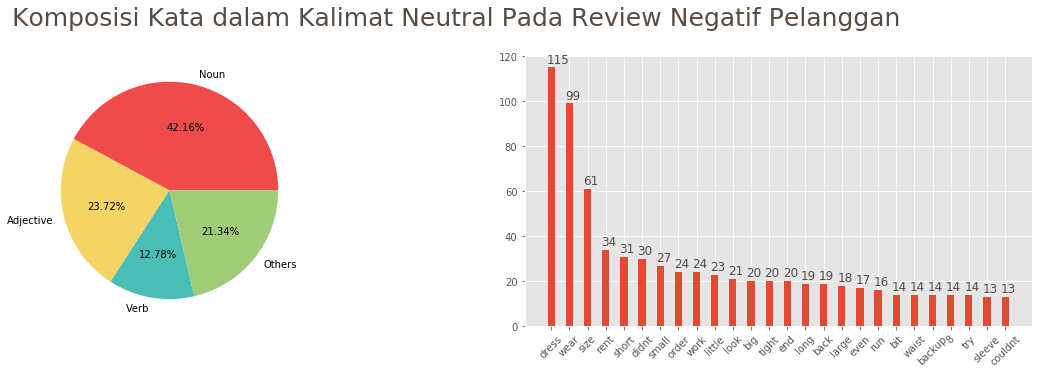

In [29]:
sums = pd.DataFrame([len(benda), len(sifat), len(kerja), len(lain2)] , index=['Noun', 'Adjective', 'Verb', 'Others'])
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Kata dalam Kalimat Neutral Pada Review Negatif Pelanggan', fontsize='25', 
             color=black, 
            va='center')

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red,yellow_,blue_, green] )

plt.subplot(122)
heights = df_kata_neu[0][0:26]
tick_labels = df_kata_neu.index.tolist()[0:26]

plt.bar(range(0, 52, 2), heights)
for i, v in enumerate(heights):
    plt.text(i*2 - 0.5,v+2 , str(v), color=black, fontsize='12')

plt.xticks(range(0,52,2),tick_labels , rotation=45)
# print(df_kata.index)
lcs, labels = plt.xticks()
# print(lcs)
plt.show()

# Memproses Kalimat Positif dalam review Negatif

In [30]:
# PREPROCESSING TEXT
dokumen_input =  pos.loc[:,0]
# neg.loc[:,0]
# selecting kalimat

print("banyak dokumen input : ", len(dokumen_input))

hasil_preprocessing = []
for i in dokumen_input:
    text = re.sub(r'[^\w\s]','',i)            # PUNCTUATION REMOVAL
    text = text.lower()                       # LOWERCASE TRANSFORMATION
    word_tokens = word_tokenize(text)         # TOKENIZING # memecah kalimat jadi kata
    
    filtered_sentence = []
    for token, tag in pos_tag(word_tokens):           # eksekusi sesuatu pada tiap token kata
        if token not in stop_words: 
            if token not in stopword:                # STOPWORD REMOVAL
                lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
    #             print(token, "=>", lemma)
                filtered_sentence.append(lemma)
#     print(filtered_sentence)
    text = (' ').join(filtered_sentence)      # REFORM SENTENCE
    hasil_preprocessing.append(text)

print("banyak dokumen hasil :", len(hasil_preprocessing))

banyak dokumen input :  265
banyak dokumen hasil : 265


In [31]:
# MENDAPATKAN SEMUA TOKEN

dokumen_input = hasil_preprocessing
dokumen_input

all_tokens = []
for i in dokumen_input:
    word_tokens = word_tokenize(i)
    all_tokens.extend(word_tokens)
all_tokens[:26]

['glad',
 'able',
 'two',
 'size',
 '4',
 'little',
 'tight',
 'wouldve',
 'make',
 'uncomfortable',
 'night',
 'dance',
 'didnt',
 'leave',
 'wardrobe',
 'best',
 'dress',
 'someone',
 'straight',
 'silhouette',
 'someone',
 'lot',
 'go',
 'hip',
 'department',
 'felt']

In [32]:
# HITUNG FREKUENSI MASING2 KATA
print("semua kata dalam token : ", len(all_tokens))
dokumen_input = all_tokens

counts = Counter(dokumen_input)
kata = counts.keys()
count_kata = counts.values()
df_x = pd.DataFrame(count_kata, index = kata)
df_x = df_x.sort_values(0,ascending=False)

kata = df_x.index
count_kata = df_x[0].tolist()

semua kata dalam token :  1782


In [33]:
dokumen_input = kata

benda = []
sifat = []
kerja = []
lain2 = []
all_tag = []
for token, tag in pos_tag(dokumen_input):
#     print(token," =>", tag)
    all_tag.append(tag)
    if tag[0] == 'N':
        benda.append(token)
    elif tag[0] == 'J':
        sifat.append(token)
    elif tag[0] == 'V':
        kerja.append(token)
    else :
        lain2.append(token)
        
df_kata_pos = df_x.copy()
df_kata_pos['POS'] = all_tag

print("jumlah semua kata unik : ", len(df_kata_pos))
print("jumlah kata benda : ", len(benda))
print("jumlah kata sifat : ", len(sifat))
print("jumlah kata kerja : ", len(kerja))
print("jumlah kata lain2 : ", len(lain2))
df_kata_pos.head(25)

jumlah semua kata unik :  669
jumlah kata benda :  300
jumlah kata sifat :  181
jumlah kata kerja :  78
jumlah kata lain2 :  110


,0,POS
dress,104,NN
fit,43,NN
wear,41,JJ
size,35,NN
look,31,NN
well,19,RB
fabric,17,JJ
rent,15,NN
color,15,NN
top,15,JJ


c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.


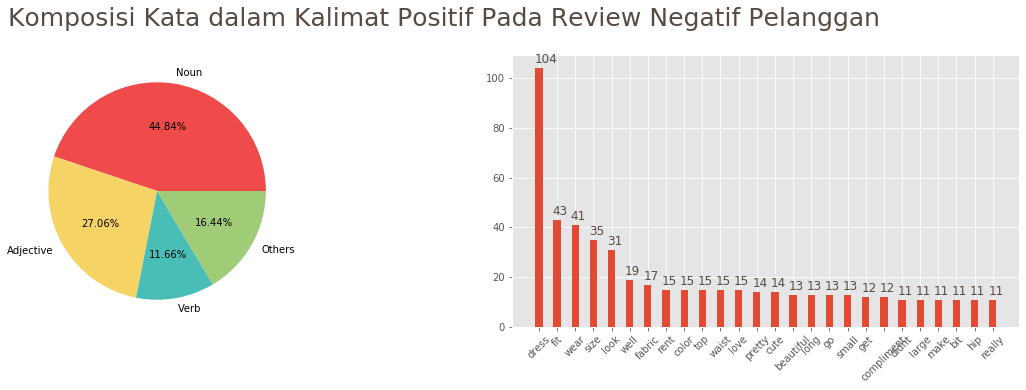

In [34]:
sums = pd.DataFrame([len(benda), len(sifat), len(kerja), len(lain2)] , index=['Noun', 'Adjective', 'Verb', 'Others'])
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Kata dalam Kalimat Positif Pada Review Negatif Pelanggan', fontsize='25', 
             color=black, 
            va='center')

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red,yellow_,blue_, green] )

plt.subplot(122)
heights = df_kata_pos[0][0:26]
tick_labels = df_kata_pos.index.tolist()[0:26]

plt.bar(range(0, 52, 2), heights)
for i, v in enumerate(heights):
    plt.text(i*2 - 0.5,v+2 , str(v), color=black, fontsize='12')

plt.xticks(range(0,52,2),tick_labels , rotation=45)
# print(df_kata.index)
lcs, labels = plt.xticks()
# print(lcs)
plt.show()

# Memproses Semua Kalimat Dalam review Negatif

In [35]:
all.loc[:,0]

0                                                                                                                       The dress arrived with a small hole in the beading on the front but wasn't too noticeable.
1                                                                                       Glad I was able to get two sizes because the 4 was a little tight and would've made for an uncomfortable night of dancing!
2                                                                                                                                                                            this was not flattering on my curves.
3                                                                                                                                                                                       Didn't leave the wardrobe!
4                                                                                                                                                           

In [36]:
# PREPROCESSING TEXT
dokumen_input =  all.loc[:,0]
# neg.loc[:,0]
# selecting kalimat

print("banyak dokumen input : ", len(dokumen_input))

hasil_preprocessing = []
for i in dokumen_input:
    text = re.sub(r'[^\w\s]','',i)            # PUNCTUATION REMOVAL
    text = text.lower()                       # LOWERCASE TRANSFORMATION
    word_tokens = word_tokenize(text)         # TOKENIZING # memecah kalimat jadi kata
    
    filtered_sentence = []
    for token, tag in pos_tag(word_tokens):           # eksekusi sesuatu pada tiap token kata
        if token not in stop_words:
            if token not in stopword:           # STOPWORD REMOVAL
                lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
    #             print(token, "=>", lemma)
                filtered_sentence.append(lemma)
#     print(filtered_sentence)
    text = (' ').join(filtered_sentence)      # REFORM SENTENCE
    hasil_preprocessing.append(text)

print("banyak dokumen hasil :", len(hasil_preprocessing))

banyak dokumen input :  1180
banyak dokumen hasil : 1180


In [37]:
# MENDAPATKAN SEMUA TOKEN

dokumen_input = hasil_preprocessing
dokumen_input

all_tokens = []
for i in dokumen_input:
    word_tokens = word_tokenize(i)
    all_tokens.extend(word_tokens)
all_tokens[:26]

['dress',
 'arrive',
 'small',
 'hole',
 'beading',
 'front',
 'wasnt',
 'noticeable',
 'glad',
 'able',
 'two',
 'size',
 '4',
 'little',
 'tight',
 'wouldve',
 'make',
 'uncomfortable',
 'night',
 'dance',
 'flatter',
 'curve',
 'didnt',
 'leave',
 'wardrobe',
 'boxy']

In [38]:
# HITUNG FREKUENSI MASING2 KATA
print("semua kata dalam token : ", len(all_tokens))
dokumen_input = all_tokens

counts = Counter(dokumen_input)
kata = counts.keys()
count_kata = counts.values()
df_x = pd.DataFrame(count_kata, index = kata)
df_x = df_x.sort_values(0,ascending=False)

kata = df_x.index
count_kata = df_x[0].tolist()

semua kata dalam token :  7502


In [39]:
dokumen_input = kata

benda = []
sifat = []
kerja = []
lain2 = []
all_tag = []
for token, tag in pos_tag(dokumen_input):
#     print(token," =>", tag)
    all_tag.append(tag)
    if tag[0] == 'N':
        benda.append(token)
    elif tag[0] == 'J':
        sifat.append(token)
    elif tag[0] == 'V':
        kerja.append(token)
    else :
        lain2.append(token)
        
df_kata_all = df_x.copy()
df_kata_all['POS'] = all_tag

print("jumlah semua kata unik : ", len(df_kata_all))
print("jumlah kata benda : ", len(benda))
print("jumlah kata sifat : ", len(sifat))
print("jumlah kata kerja : ", len(kerja))
print("jumlah kata lain2 : ", len(lain2))
df_kata_all.head(25)

jumlah semua kata unik :  1514
jumlah kata benda :  682
jumlah kata sifat :  405
jumlah kata kerja :  175
jumlah kata lain2 :  252


,0,POS
dress,380,NN
wear,224,JJ
size,139,NN
fit,107,NN
didnt,106,NN
look,95,VBP
rent,63,VB
small,58,JJ
little,54,JJ
short,53,JJ


c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.


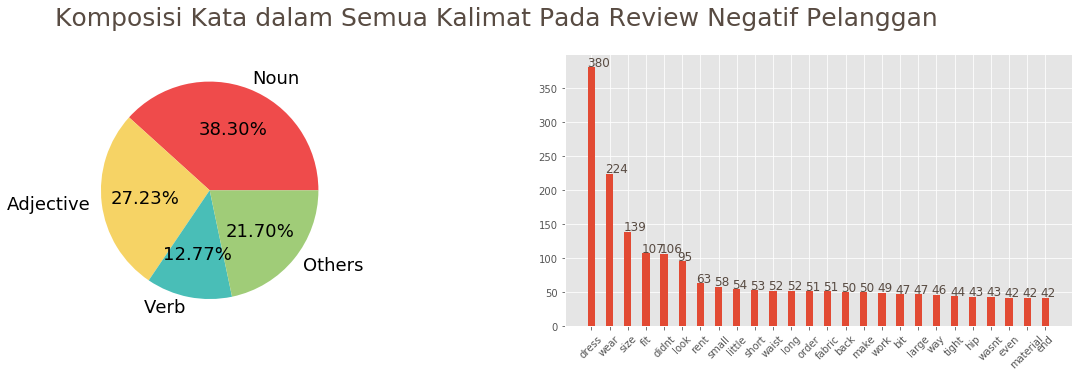

In [51]:
sums = pd.DataFrame([len(benda), len(sifat), len(kerja), len(lain2)] , index=['Noun', 'Adjective', 'Verb', 'Others'])
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Kata dalam Semua Kalimat Pada Review Negatif Pelanggan', fontsize='25', 
             color=black, 
            va='center')

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red,yellow_,blue_, green] , textprops={'fontsize': 14})

plt.subplot(122)
heights = df_kata_all[0][0:26]
tick_labels = df_kata_all.index.tolist()[0:26]

plt.bar(range(0, 52, 2), heights)
for i, v in enumerate(heights):
    plt.text(i*2 - 0.5,v+2 , str(v), color=black, fontsize='12')

plt.xticks(range(0,52,2),tick_labels , rotation=45)
# print(df_kata.index)
lcs, labels = plt.xticks()
# print(lcs)
plt.show()

======== MEMBUAT WORDCLOUD REVIEW NEGATIF=========


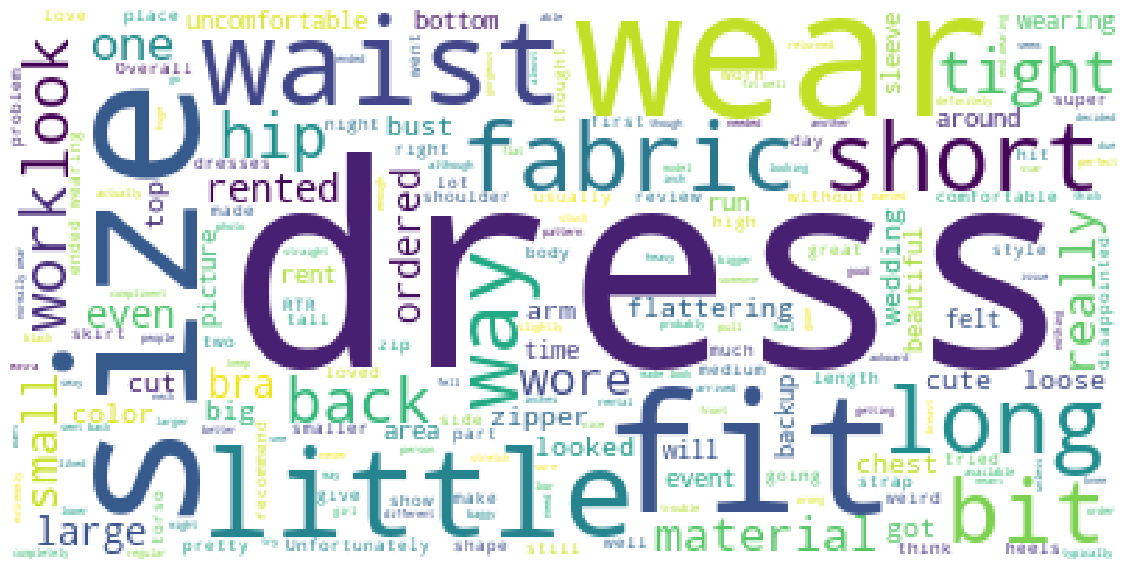

In [41]:

print("======== MEMBUAT WORDCLOUD REVIEW NEGATIF=========")
#print(semua)

semua = ''.join(all.loc[:,0])
wordcloud = WordCloud(stopwords = stopword, background_color="white").generate(semua)
rcParams['figure.figsize'] = 20,20
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Melihat kelompok Term yang Sering Muncul 

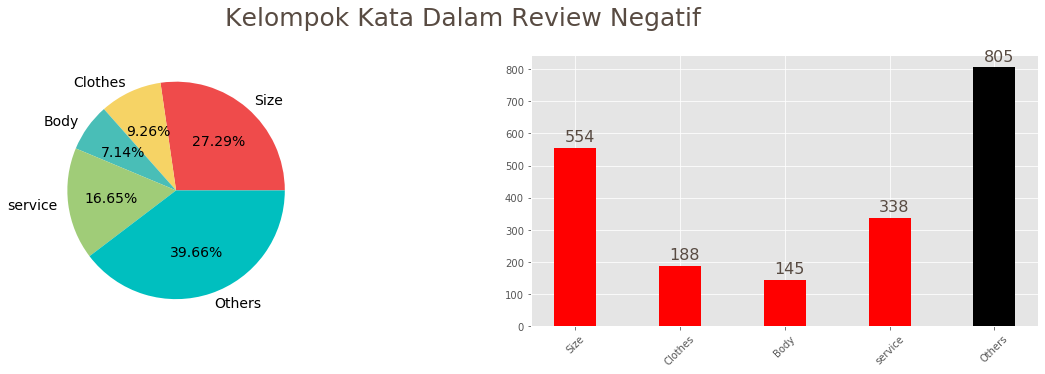

In [70]:
heights = df_kata_all[0][0:26]
tick_labels = df_kata_all.index.tolist()[0:26]
tick_labels


size_term = ['size', 'fit', 'small', 'little', 'short', 'long', 'large', 'tight', 'low']
cloth_term = ['look', 'fabric', 'material', 'bra', 'cut', 'loose', 'zipper', 'picture']
body_term = ['waist', 'back', 'hip']
service_term = ['wear', 'rent' , 'order']
general = [ 'dress','didnt', 'work', 'bit', 'way', 'wasnt', 'even', 'end', 'one', 'bit', 'area', 'love', 'really', 'make']


counts_term = [0,0,0,0, 0]
for i in tick_labels:
    n = heights[tick_labels.index(i)]
    if i in size_term:
        counts_term[0]+= n
    elif i in cloth_term:
        counts_term[1]+=n
    elif i in body_term:
        counts_term[2]+= n
    elif i in service_term:
        counts_term[3]+= n
    else:
        counts_term[4]+=n
            
# print(counts_term)

fig = plt.figure(figsize=(20,5))
plt.suptitle("Kelompok Kata Dalam Review Negatif", fontsize='25', 
             color=black, 
            va='center')

plt.subplot(121)
plt.pie(counts_term, labels=['Size', 'Clothes', 'Body', 'service',"Others"], autopct='%1.2f%%',colors=[red,yellow_,blue_, green,'c'], textprops={'fontsize': 14} )


plt.subplot(122)
tick_labels = ['Size', 'Clothes', 'Body', 'service',"Others"]
plt.bar(range(0, 10, 2), counts_term, color=['r', 'r','r', 'r','k'])
rcParams['axes.titlepad'] = 5 

for i, v in enumerate(counts_term):
    plt.text(i*2+.3 - 0.5,v+20 , str(v), color=black, fontsize='16')
plt.xticks(range(0,10,2),tick_labels, rotation=45)


plt.show()

# Menganalisa kembali transaksi-transaksi yang mendapat feed back sangat buruk
#### - rating kurang dari 6
#### - sentiment review negatif
#### - feedback ukuran pakaian tidak fit (small/large)

In [43]:
df_very_negatif = df_rent[df_rent['rating'] < 6][df_rent['sentiment_']=='negative'][df_rent['fit'] != 'fit']
df_very_negatif.shape

c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(61, 23)

In [44]:
df_very_negatif.loc[:, 'review_text'][:5]

555                                                      This dress makes younger girls look a little bit old which was completely unexpected. When I finally fit into the size bigger than I usually am, the dress turned out to be extremely unflattering. There is ribbing on the sides that makes your torso look about 2 inches wider than it actually is, and the tightness around the hips pull in a strange and unsavory way. I didn't end up wearing the dress, and I wouldn't recommend it.
1049    This was my backup if the short version of the dress was too short and I decided not to wear it. I am very tall, but this hem hit me in the most unfortunate spot. Sort or an inch or two above the ankle. So bad. If I wasn't so curvy in the tummy and butt, maybe it would have laid better, but it was just awful. I guess the 22L would have been better (I thought I did order the long). The short one looked fun and sexy, where as the long one looked matronly and heavy. Hated it!
1412                        

In [45]:
# PREPROCESSING TEXT
dokumen_input =  df_very_negatif.loc[:, 'review_text']
# neg.loc[:,0]
# selecting kalimat

print("banyak dokumen input : ", len(dokumen_input))

hasil_preprocessing = []
for i in dokumen_input:
    text = re.sub(r'[^\w\s]','',i)            # PUNCTUATION REMOVAL
    text = text.lower()                       # LOWERCASE TRANSFORMATION
    word_tokens = word_tokenize(text)         # TOKENIZING # memecah kalimat jadi kata
    
    filtered_sentence = []
    for token, tag in pos_tag(word_tokens):           # eksekusi sesuatu pada tiap token kata
        if token not in stop_words:
            if token not in stopword:           # STOPWORD REMOVAL
                lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
    #             print(token, "=>", lemma)
                filtered_sentence.append(lemma)
#     print(filtered_sentence)
    text = (' ').join(filtered_sentence)      # REFORM SENTENCE
    hasil_preprocessing.append(text)

print("banyak dokumen hasil :", len(hasil_preprocessing))

banyak dokumen input :  61
banyak dokumen hasil : 61


In [46]:
# MENDAPATKAN SEMUA TOKEN

dokumen_input = hasil_preprocessing
dokumen_input

all_tokens = []
for i in dokumen_input:
    word_tokens = word_tokenize(i)
    all_tokens.extend(word_tokens)
all_tokens[:26]

['dress',
 'make',
 'young',
 'girl',
 'look',
 'little',
 'bit',
 'old',
 'completely',
 'unexpected',
 'finally',
 'fit',
 'size',
 'big',
 'usually',
 'dress',
 'turn',
 'extremely',
 'unflattering',
 'rib',
 'side',
 'make',
 'torso',
 'look',
 '2',
 'inch']

In [47]:
# HITUNG FREKUENSI MASING2 KATA
print("semua kata dalam token : ", len(all_tokens))
dokumen_input = all_tokens

counts = Counter(dokumen_input)
kata = counts.keys()
count_kata = counts.values()
df_x = pd.DataFrame(count_kata, index = kata)
df_x = df_x.sort_values(0,ascending=False)

kata = df_x.index
count_kata = df_x[0].tolist()

semua kata dalam token :  1194


In [48]:
dokumen_input = kata

benda = []
sifat = []
kerja = []
lain2 = []
all_tag = []
for token, tag in pos_tag(dokumen_input):
#     print(token," =>", tag)
    all_tag.append(tag)
    if tag[0] == 'N':
        benda.append(token)
    elif tag[0] == 'J':
        sifat.append(token)
    elif tag[0] == 'V':
        kerja.append(token)
    else :
        lain2.append(token)
        
df_kata_v_neg = df_x.copy()
df_kata_v_neg['POS'] = all_tag

print("jumlah semua kata unik : ", len(df_kata_v_neg))
print("jumlah kata benda : ", len(benda))
print("jumlah kata sifat : ", len(sifat))
print("jumlah kata kerja : ", len(kerja))
print("jumlah kata lain2 : ", len(lain2))
df_kata_v_neg.head(25)

jumlah semua kata unik :  1514
jumlah kata benda :  180
jumlah kata sifat :  128
jumlah kata kerja :  60
jumlah kata lain2 :  102


,0,POS
dress,66,NN
wear,40,JJ
fit,31,JJ
look,25,NN
size,23,NN
didnt,20,NNS
short,15,JJ
way,14,NN
even,13,RB
waist,13,JJ


c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.


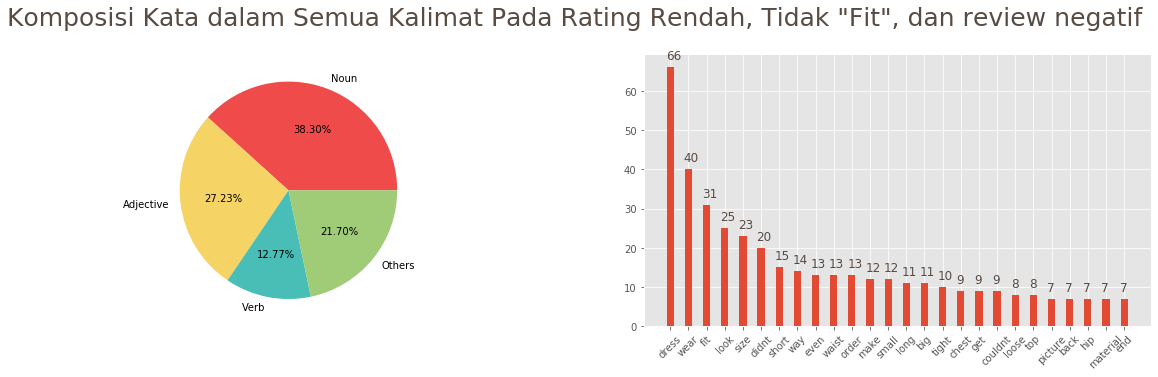

In [49]:
sums = pd.DataFrame([len(benda), len(sifat), len(kerja), len(lain2)] , index=['Noun', 'Adjective', 'Verb', 'Others'])
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Kata dalam Semua Kalimat Pada Rating Rendah, Tidak "Fit", dan review negatif', fontsize='25', 
             color=black, 
            va='center')

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red,yellow_,blue_, green] )

plt.subplot(122)
heights = df_kata_v_neg[0][0:26]
tick_labels = df_kata_v_neg.index.tolist()[0:26]

plt.bar(range(0, 52, 2), heights)
for i, v in enumerate(heights):
    plt.text(i*2 - 0.5,v+2 , str(v), color=black, fontsize='12')

plt.xticks(range(0,52,2),tick_labels , rotation=45)
# print(df_kata.index)
lcs, labels = plt.xticks()
# print(lcs)
plt.show()

======== MEMBUAT WORDCLOUD REVIEW VERY NEGATIF=========


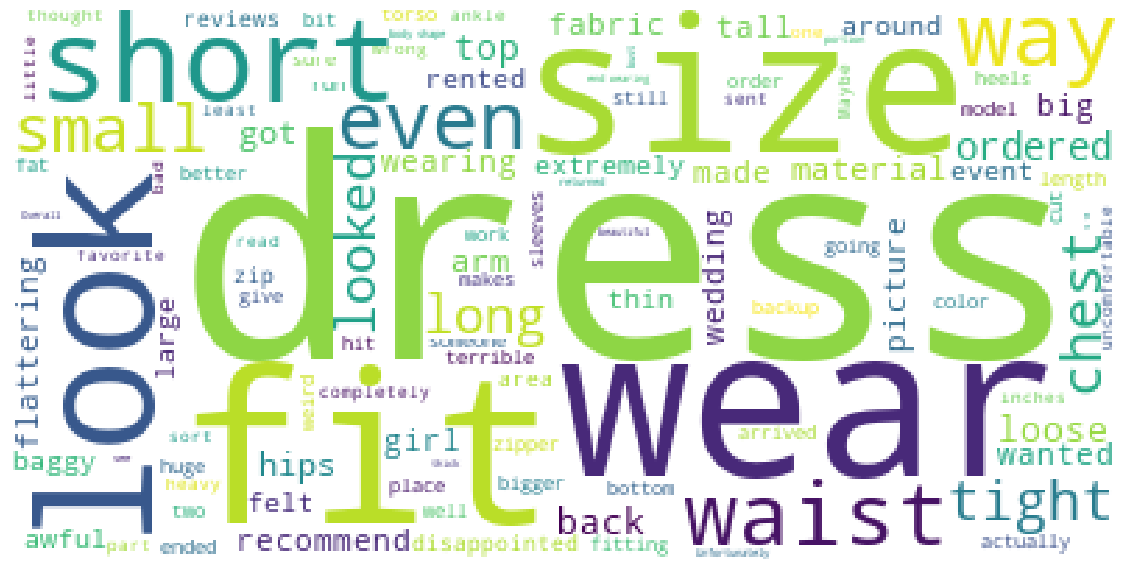

In [50]:

print("======== MEMBUAT WORDCLOUD REVIEW VERY NEGATIF=========")
#print(semua)

semua = ''.join(df_very_negatif.loc[:, 'review_text'])
wordcloud = WordCloud(stopwords = stopword, background_color="white").generate(semua)
rcParams['figure.figsize'] = 20,20
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

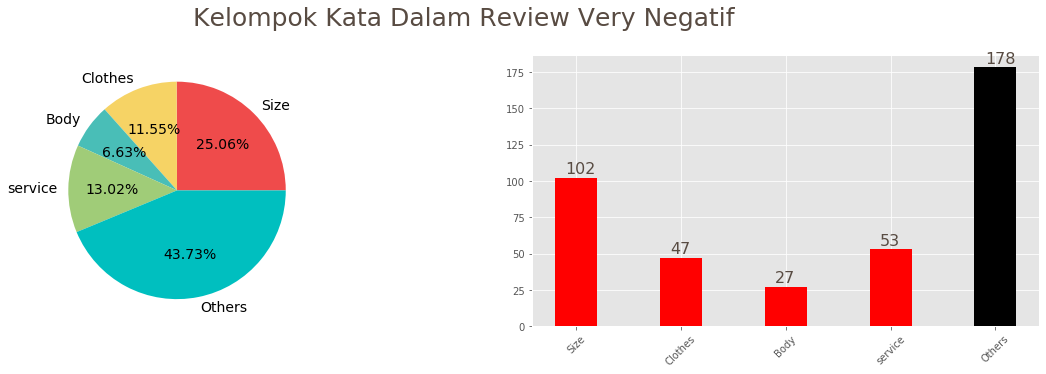

In [71]:
heights = df_kata_v_neg[0][0:26]
tick_labels = df_kata_v_neg.index.tolist()[0:26]
tick_labels

size_term = ['size', 'fit', 'small', 'little', 'short', 'long', 'large', 'tight', 'low']
cloth_term = ['look', 'fabric', 'material', 'bra', 'cut', 'loose', 'zipper', 'picture']
body_term = ['waist', 'back', 'hip']
service_term = ['wear', 'rent' , 'order']
general = [ 'dress','didnt', 'work', 'bit', 'way', 'wasnt', 'even', 'end', 'one', 'bit', 'area', 'love', 'really', 'make']


counts_term = [0,0,0,0, 0]
for i in tick_labels:
    n = heights[tick_labels.index(i)]
    if i in size_term:
        counts_term[0]+= n
    elif i in cloth_term:
        counts_term[1]+=n
    elif i in body_term:
        counts_term[2]+= n
    elif i in service_term:
        counts_term[3]+= n
    else:
        counts_term[4]+=n
            
# print(counts_term)

fig = plt.figure(figsize=(20,5))
plt.suptitle("Kelompok Kata Dalam Review Very Negatif", fontsize='25', 
             color=black, 
            va='center')

plt.subplot(121)
plt.pie(counts_term, labels=['Size', 'Clothes', 'Body', 'service',"Others"], autopct='%1.2f%%',colors=[red,yellow_,blue_, green,'c'], textprops={'fontsize': 14} )


plt.subplot(122)
tick_labels = ['Size', 'Clothes', 'Body', 'service',"Others"]
plt.bar(range(0, 10, 2), counts_term, color=['r', 'r','r', 'r','k'])
rcParams['axes.titlepad'] = 5 

for i, v in enumerate(counts_term):
    plt.text(i*2+.3 - 0.5,v+3 , str(v), color=black, fontsize='16')
plt.xticks(range(0,10,2),tick_labels, rotation=45)


plt.show()